In [63]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append('../code/')
import d2lzh_pytorch as d2l
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)

1.3.0


In [64]:
train_data=pd.read_csv('../data/kaggle_house/train.csv')
test_data=pd.read_csv('../data/kaggle_house/test.csv')

In [65]:
train_data.shape

(1460, 81)

In [66]:
test_data.shape

(1459, 80)

In [67]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [68]:
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [69]:
all_features.shape

(2919, 79)

In [70]:
all_features.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

In [71]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index

In [72]:
numeric_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [73]:
all_features[numeric_features]=all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))

In [74]:
all_features = all_features.fillna(0)

In [75]:
all_features.shape

(2919, 79)

In [76]:
all_features.MSZoning

0       RL
1       RL
2       RL
3       RL
4       RL
        ..
1454    RM
1455    RM
1456    RL
1457    RL
1458    RL
Name: MSZoning, Length: 2919, dtype: object

In [86]:
all_features=pd.get_dummies(all_features,dummy_na=True)#https://blog.csdn.net/maymay_/article/details/80198468
all_features.shape

(2919, 354)

In [87]:
all_features.MSZoning_RM

0       0
1       0
2       0
3       0
4       0
       ..
1454    1
1455    1
1456    0
1457    0
1458    0
Name: MSZoning_RM, Length: 2919, dtype: uint8

In [88]:
n_train = train_data.shape[0]
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float)
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float)
train_labels=torch.tensor(train_data.SalePrice.values,dtype=torch.float)

In [90]:
train_features.shape

torch.Size([1460, 354])

In [91]:
test_features.shape

torch.Size([1459, 354])

In [92]:
loss=torch.nn.MSELoss()

def get_net(feature_num):
    net=nn.Linear(feature_num,1)
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return net

In [94]:
def log_rmse(net,features,labels):
    with torch.no_grad():
        clipped_preds=torch.max(net(features),torch.tensor(1.0))
        rmse=torch.sqrt(2*loss(clipped_preds.log(),labels.log()).mean())
    return rmse.item()

In [95]:
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls=[],[]
    dataset=torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter=torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    optimizer=torch.optim.Adam(params=net.parameters(),lr=learning_rate)
    net=net.float()
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l=loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [96]:
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [97]:
def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1168])) that is different to the input size (torch.Size([1168, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

fold 0, train rmse 0.578758, valid rmse 0.552921
fold 1, train rmse 0.563837, valid rmse 0.607843
fold 2, train rmse 0.570007, valid rmse 0.584054
fold 3, train rmse 0.580323, valid rmse 0.562316
fold 4, train rmse 0.576669, valid rmse 0.559865
5-fold validation: avg train rmse 0.573919, avg valid rmse 0.573400


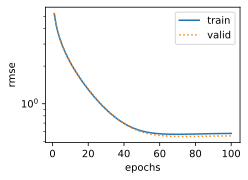

In [98]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))


In [99]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1460])) that is different to the input size (torch.Size([1460, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train rmse 0.576200


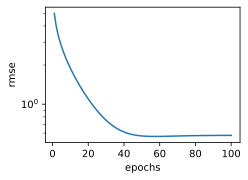

In [100]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)